<a href="https://colab.research.google.com/github/acvdp/Item-Demand-Forecasting/blob/main/datasets/GenDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset mejorado generado con éxito!
Registros: 547,500 | Periodo: 2021-01-01 al 2023-12-31


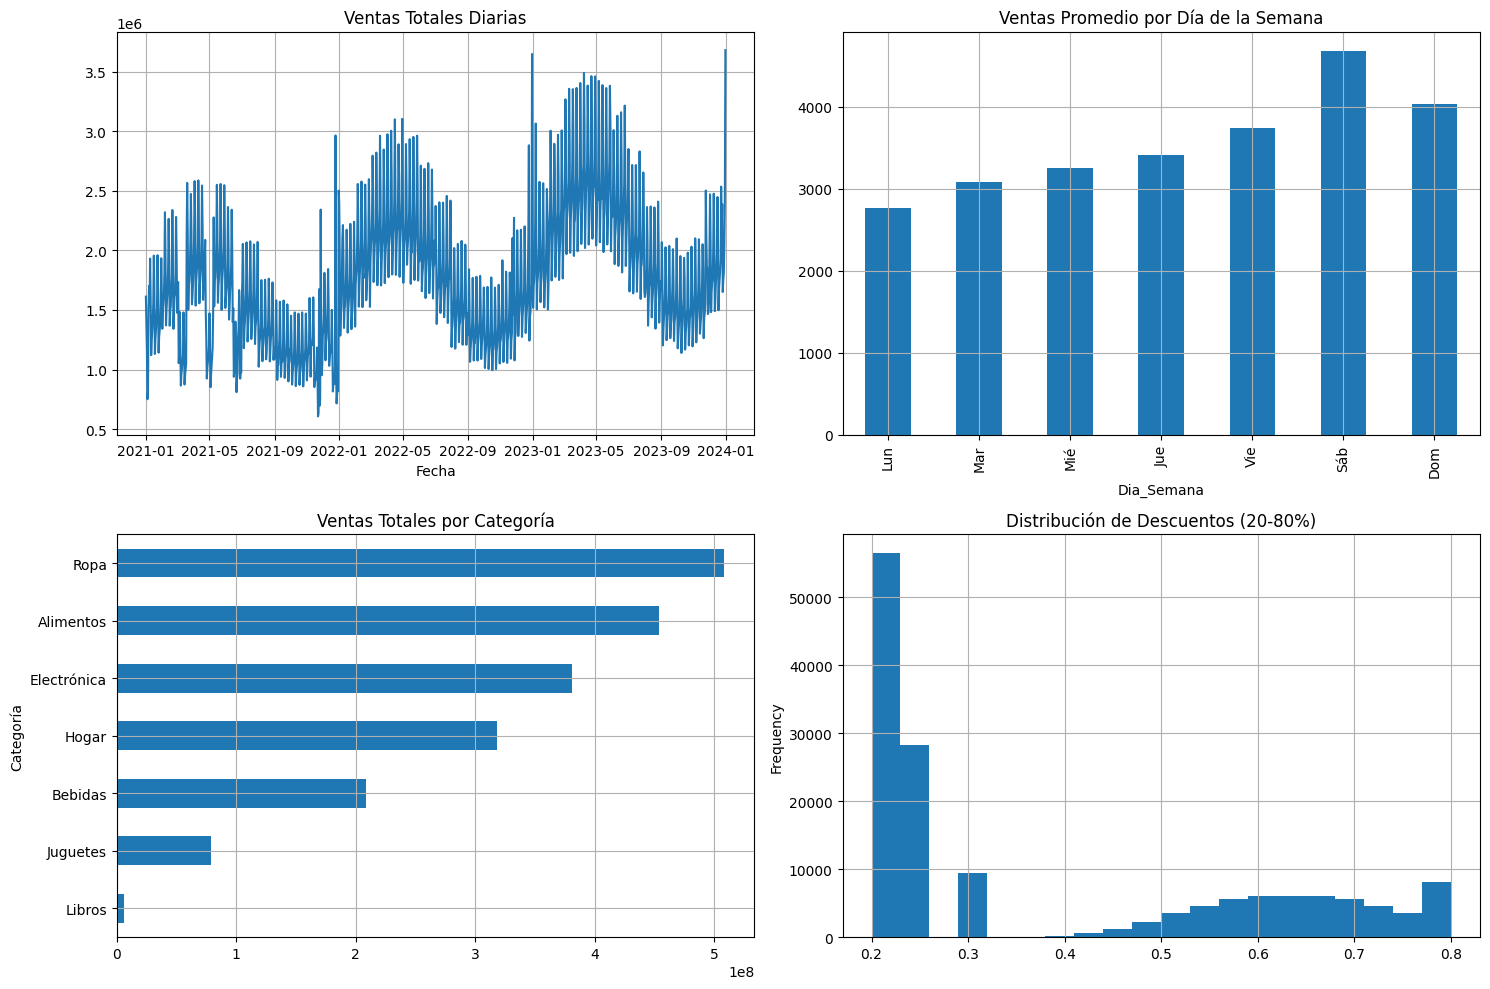

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Configuración
np.random.seed(42)
n_dias = 365 * 3  # 3 años de datos
n_productos = 50
n_tiendas = 10

# 1. Definir festivos nacionales de España + eventos comerciales
festivos_espana = {
    # Festivos nacionales
    (1, 1): "Año Nuevo",
    (1, 6): "Reyes Magos",
    (3, 19): "Día del Padre",
    (5, 9): "Día de la Madre",
    (12, 25): "Navidad",
    (12, 31): "Nochevieja",

    # Eventos comerciales
    (11, 24): "Black Friday",
    (11, 27): "Cyber Monday",
    (1, 7): "Rebajas de Invierno",
    (7, 1): "Rebajas de Verano"
}

# Diccionario inverso para búsqueda de fechas
festivos_fechas = {v: datetime(2021, k[0], k[1]).date() for k, v in festivos_espana.items()}

# 2. Funciones para festivos y efectos anticipatorios mejorados
def es_festivo(fecha):
    return (fecha.month, fecha.day) in festivos_espana

def obtener_tipo_festivo(fecha):
    return festivos_espana.get((fecha.month, fecha.day), "No festivo")

def aplicar_efecto_festivo(fecha, categoria):
    nombre_festivo = obtener_tipo_festivo(fecha)
    efecto = 1.0

    # Efectos directos de festivos (más pronunciados)
    efectos_directos = {
        "Navidad": {"Juguetes": 6.0, "Alimentos": 3.5, "Ropa": 2.5, "Bebidas": 3.0, "Hogar": 2.0},
        "Reyes Magos": {"Juguetes": 4.5, "Libros": 3.0, "Ropa": 1.8},
        "Nochevieja": {"Alimentos": 4.0, "Bebidas": 5.0, "Hogar": 2.5},
        "Black Friday": {"Electrónica": 7.0, "Hogar": 4.0, "Ropa": 3.5},
        "Cyber Monday": {"Electrónica": 5.0, "Libros": 2.0},
        "Rebajas de Invierno": {"Ropa": 4.0, "Electrónica": 3.0, "Hogar": 2.5},
        "Rebajas de Verano": {"Ropa": 3.5, "Hogar": 2.0, "Bebidas": 1.8}
    }

    # Efectos anticipatorios mejorados (15 días antes con progresión)
    efectos_previos = {
        "Navidad": [{"dias": i, "factor": 0.05*i} for i in range(15, 0, -1)],
        "Reyes Magos": [{"dias": i, "factor": 0.04*i} for i in range(10, 0, -1)],
        "Nochevieja": [{"dias": i, "factor": 0.03*i} for i in range(7, 0, -1)],
        "Black Friday": [{"dias": i, "factor": 0.06*i} for i in range(15, 0, -1)],
        "Rebajas de Invierno": [{"dias": i, "factor": 0.04*i} for i in range(7, 0, -1)],
        "Rebajas de Verano": [{"dias": i, "factor": 0.04*i} for i in range(7, 0, -1)]
    }

    # Comprobar si es festivo
    if es_festivo(fecha):
        efecto = efectos_directos.get(nombre_festivo, {}).get(categoria, 1.8)
    else:
        # Comprobar días previos con efectos progresivos
        for festivo, previos in efectos_previos.items():
            fecha_festivo = festivos_fechas[festivo]
            for previo in previos:
                if fecha == fecha_festivo - timedelta(days=previo["dias"]):
                    # Añadir aleatoriedad al efecto
                    efecto = 1 + previo["factor"] * np.random.uniform(0.8, 1.2)
                    break

    return efecto

# 3. Generar datos maestros con lambdas diferentes por categoría
categorias = ['Electrónica', 'Ropa', 'Alimentos', 'Hogar', 'Juguetes', 'Libros', 'Bebidas']
lambdas_categorias = {
    'Electrónica': 8,
    'Ropa': 12,
    'Alimentos': 15,
    'Hogar': 10,
    'Juguetes': 6,
    'Libros': 4,
    'Bebidas': 14
}

productos = [f"SKU-{i:03d}" for i in range(n_productos)]
categorias_productos = np.random.choice(categorias, size=n_productos, p=[0.2, 0.25, 0.15, 0.15, 0.1, 0.05, 0.1])
precios_base = np.round(np.random.uniform(5, 500, n_productos), 2)

tiendas = [f"Tienda-{i:02d}" for i in range(1, n_tiendas+1)]
regiones = np.random.choice(['Norte', 'Sur', 'Este', 'Oeste'], size=n_tiendas)

# 4. Generar dataset con tendencia anual creciente y días de semana diferenciados
data = []
for i, fecha in enumerate([datetime(2021,1,1) + timedelta(days=i) for i in range(n_dias)]):
    fecha = fecha.date()

    # Tasa de crecimiento anual compuesta del 15%
    factor_crecimiento = (1.15) ** (i / 365)

    # Definir periodo festivo (15 días antes de cada festivo)
    es_periodo_festivo = False
    for festivo_date in festivos_fechas.values():
        for d in range(0, 16):  # 15 días antes + día festivo
            if fecha == festivo_date - timedelta(days=d):
                es_periodo_festivo = True
                break
        if es_periodo_festivo:
            break

    for tienda_idx, tienda in enumerate(tiendas):
        for producto_idx, producto in enumerate(productos):
            # Variables base
            precio = precios_base[producto_idx]
            categoria = categorias_productos[producto_idx]
            lam = lambdas_categorias[categoria]

            # Descuentos más significativos (20-80%) y realistas
            if es_periodo_festivo or es_festivo(fecha):
                # Base + variabilidad por categoría/tienda
                desc_base = 0.3  # 30% base en festivos
                desc_cat = {
                    'Electrónica': 0.25,
                    'Ropa': 0.35,
                    'Alimentos': 0.15,
                    'Hogar': 0.2,
                    'Juguetes': 0.4,
                    'Libros': 0.1,
                    'Bebidas': 0.2
                }[categoria]

                # Añadir variabilidad según tipo de festivo
                nombre_festivo = obtener_tipo_festivo(fecha)
                if "Rebajas" in nombre_festivo:
                    desc_base += 0.1
                elif "Black Friday" in nombre_festivo:
                    desc_base += 0.15

                desc_tienda = tienda_idx * 0.02  # Tienda 01: +0%, Tienda 10: +0.18%
                descuento = min(0.8, max(0.2, desc_base + desc_cat + desc_tienda + np.random.uniform(-0.05, 0.05)))
            else:
                # Descuentos menores fuera de festivos (0-30%)
                prob_descuento = 0.3 if fecha.weekday() in [5,6] else 0.15  # Más descuentos en fin de semana
                if np.random.random() < prob_descuento:
                    descuento = np.random.choice([0.2, 0.25, 0.3], p=[0.6, 0.3, 0.1])
                else:
                    descuento = 0

            precio_final = precio * (1 - descuento)

            # Factores temporales con días de semana diferenciados
            mes = fecha.month
            dia_semana = fecha.weekday()

            # Probabilidades de venta por día de semana (0=lunes, 6=domingo)
            factores_dia_semana = {
                0: 0.9,  # Lunes
                1: 1.0,  # Martes
                2: 1.05, # Miércoles
                3: 1.1,  # Jueves
                4: 1.2,  # Viernes
                5: 1.5,  # Sábado
                6: 1.3   # Domingo
            }

            factor_dia = factores_dia_semana[dia_semana] * np.random.uniform(0.9, 1.1)

            # Estacionalidad con tendencia anual creciente
            factor_estacional = (1 + 0.3 * np.sin(2*np.pi*(mes-1)/12)) * factor_crecimiento

            # Efecto festivo/anticipatorio mejorado
            factor_festivo = aplicar_efecto_festivo(fecha, categoria)

            # Cálculo de ventas con lambdas por categoría
            ventas_base = np.random.poisson(lam=lam)
            cantidad = int(max(1, ventas_base * factor_estacional * factor_dia * factor_festivo * (1 + 0.9*descuento)))

            data.append({
                'Fecha': fecha,
                'Tienda': tienda,
                'Región': regiones[tienda_idx],
                'Producto': producto,
                'Categoría': categoria,
                'Precio_Base': precio,
                'Descuento': descuento,
                'Precio_Final': precio_final,
                'Cantidad_Vendida': cantidad,
                'Ventas': cantidad * precio_final,
                'Dia_Semana': dia_semana,
                'Mes': mes,
                'Festivo': es_festivo(fecha),
                'Periodo_Festivo': es_periodo_festivo,
                'Nombre_Festivo': obtener_tipo_festivo(fecha),
                'Promoción': descuento > 0
            })

# 5. Crear y guardar DataFrame
df = pd.DataFrame(data)
df.to_csv('dataset_ventas_retail_espana_final.csv', index=False, encoding='utf-8-sig')
print("Dataset mejorado generado con éxito!")
print(f"Registros: {len(df):,} | Periodo: {df['Fecha'].min()} al {df['Fecha'].max()}")

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Ventas totales diarias
plt.subplot(2, 2, 1)
df.groupby('Fecha')['Ventas'].sum().plot(title='Ventas Totales Diarias')
plt.grid(True)

# Ventas por día de la semana
plt.subplot(2, 2, 2)
df.groupby('Dia_Semana')['Ventas'].mean().plot(kind='bar', title='Ventas Promedio por Día de la Semana')
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
plt.grid(True)

# Ventas por categoría
plt.subplot(2, 2, 3)
df.groupby('Categoría')['Ventas'].sum().sort_values().plot(kind='barh', title='Ventas Totales por Categoría')
plt.grid(True)

# Descuentos aplicados
plt.subplot(2, 2, 4)
df[df['Descuento'] > 0]['Descuento'].plot(kind='hist', bins=20, title='Distribución de Descuentos (20-80%)')
plt.grid(True)

plt.tight_layout()
plt.show()

Dataset mejorado generado con éxito!
Registros: 547,500 | Periodo: 2021-01-01 al 2023-12-31


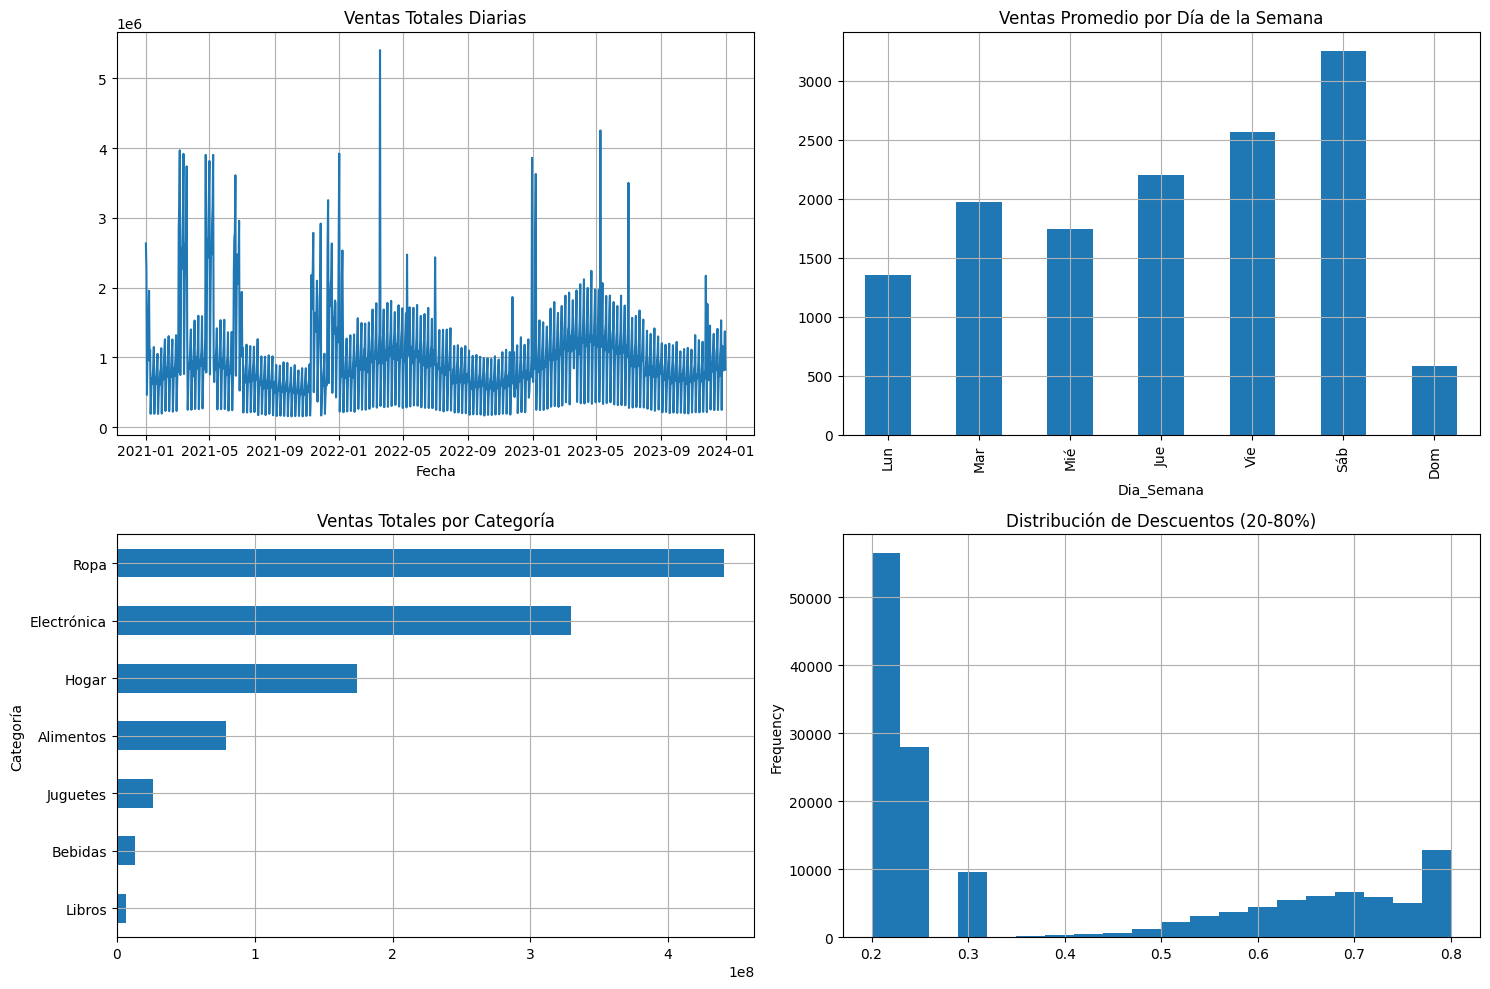

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Configuración
np.random.seed(42)
n_dias = 365 * 3  # 3 años de datos
n_productos = 50
n_tiendas = 10

# 1. Definir festivos nacionales de España + eventos comerciales
festivos_espana = {
    # Festivos nacionales
    (1, 1): "Año Nuevo",
    (1, 6): "Reyes Magos",
    (3, 19): "Día del Padre",
    (5, 9): "Día de la Madre",
    (12, 25): "Navidad",
    (12, 31): "Nochevieja",

    # Eventos comerciales
    (11, 24): "Black Friday",
    (11, 27): "Cyber Monday",
    (1, 7): "Rebajas de Invierno",
    (7, 1): "Rebajas de Verano"
}

# Diccionario inverso para búsqueda de fechas
festivos_fechas = {v: datetime(2021, k[0], k[1]).date() for k, v in festivos_espana.items()}

# 2. Funciones para festivos y efectos anticipatorios mejorados
def es_festivo(fecha):
    return (fecha.month, fecha.day) in festivos_espana

def obtener_tipo_festivo(fecha):
    return festivos_espana.get((fecha.month, fecha.day), "No festivo")

def aplicar_efecto_festivo(fecha, categoria):
    nombre_festivo = obtener_tipo_festivo(fecha)
    efecto = 1.5

    # Efectos directos de festivos (más pronunciados)
    efectos_directos = {
      "Año Nuevo": {"Alimentos": 1.75, "Bebidas": 1.25, "Hogar": 0.875},
      "Nochevieja": {"Alimentos": 1.75, "Bebidas": 1.25, "Hogar": 0.875},
      "Navidad": {"Juguetes": 1.5, "Alimentos": 0.875, "Ropa": 0.75, "Bebidas": 0.75, "Hogar": 0.5},
      "Reyes Magos": {"Juguetes": 1.125, "Libros": 0.75, "Ropa": 1.375, "Electrónica": 0.75},
      "Black Friday": {"Electrónica": 1.25, "Hogar": 0.75, "Ropa": 1.0},
      "Rebajas de Invierno": {"Ropa": 1.25, "Electrónica": 0.5},
      "Cyber Monday": {"Electrónica": 1.25, "Libros": 0.5},
      "Rebajas de Verano": {"Ropa": 0.875, "Hogar": 0.5, "Bebidas": 0.45}
    }

    # Efectos anticipatorios mejorados (15 días antes con progresión)
    efectos_previos = {
        "Navidad": [{"dias": i, "factor": 0.05*i} for i in range(15, 0, -1)],
        "Reyes Magos": [{"dias": i, "factor": 0.04*i} for i in range(10, 0, -1)],
        "Nochevieja": [{"dias": i, "factor": 0.03*i} for i in range(7, 0, -1)],
        "Black Friday": [{"dias": i, "factor": 0.06*i} for i in range(15, 0, -1)],
        "Rebajas de Invierno": [{"dias": i, "factor": 0.04*i} for i in range(7, 0, -1)],
        "Rebajas de Verano": [{"dias": i, "factor": 0.04*i} for i in range(7, 0, -1)]
    }

    # Comprobar si es festivo
    if es_festivo(fecha):
        efecto = efectos_directos.get(nombre_festivo, {}).get(categoria, 1.8)
    else:
        # Comprobar días previos con efectos progresivos
        for festivo, previos in efectos_previos.items():
            fecha_festivo = festivos_fechas[festivo]
            for previo in previos:
                if fecha == fecha_festivo - timedelta(days=previo["dias"]):
                    # Añadir aleatoriedad al efecto
                    efecto = 1 + previo["factor"] * np.random.uniform(0.8, 1.2)
                    break

    return efecto

# 3. Generar datos maestros con lambdas diferentes por categoría
categorias = ['Electrónica', 'Ropa', 'Alimentos', 'Hogar', 'Juguetes', 'Libros', 'Bebidas']
lambdas_categorias = {
    'Electrónica': 3,
    'Ropa': 7,
    'Alimentos': 10,
    'Hogar': 4,
    'Juguetes': 2,
    'Libros': 2,
    'Bebidas': 6
}

productos = [f"SKU-{i:03d}" for i in range(n_productos)]
categorias_productos = np.random.choice(categorias, size=n_productos, p=[0.15, 0.20, 0.15, 0.15, 0.1, 0.1, 0.15])
rangos_precios = {
    'Electrónica': (50, 2000),
    'Ropa': (10, 300),
    'Alimentos': (1, 100),
    'Hogar': (15, 500),
    'Juguetes': (5, 150),
    'Libros': (8, 80),
    'Bebidas': (1, 50)
}

precios_base = np.round([np.random.uniform(*rangos_precios[cat]) for cat in categorias_productos], 2)

tiendas = [f"Tienda-{i:02d}" for i in range(1, n_tiendas+1)]
regiones = np.random.choice(['Norte', 'Sur', 'Este', 'Oeste'], size=n_tiendas)

# 4. Generar dataset con tendencia anual creciente y días de semana diferenciados
data = []
for i, fecha in enumerate([datetime(2021,1,1) + timedelta(days=i) for i in range(n_dias)]):
    fecha = fecha.date()

    # Tasa de crecimiento anual compuesta del 15%
    factor_crecimiento = (1.15) ** (i / 365)

    # Definir periodo festivo (15 días antes de cada festivo)
    es_periodo_festivo = False
    for festivo_date in festivos_fechas.values():
        for d in range(0, 16):  # 15 días antes + día festivo
            if fecha == festivo_date - timedelta(days=d):
                es_periodo_festivo = True
                break
        if es_periodo_festivo:
            break

    for tienda_idx, tienda in enumerate(tiendas):
        for producto_idx, producto in enumerate(productos):
            # Variables base
            precio = precios_base[producto_idx]
            categoria = categorias_productos[producto_idx]
            lam = lambdas_categorias[categoria]

            # Descuentos más significativos (20-80%) y realistas
            if es_periodo_festivo or es_festivo(fecha):
                # Base + variabilidad por categoría/tienda
                desc_base = 0.3  # 30% base en festivos
                desc_cat = {
                    'Electrónica': 0.25,
                    'Ropa': 0.35,
                    'Alimentos': 0.35,
                    'Hogar': 0.2,
                    'Juguetes': 0.4,
                    'Libros': 0.1,
                    'Bebidas': 0.25
                }[categoria]

                # Añadir variabilidad según tipo de festivo
                nombre_festivo = obtener_tipo_festivo(fecha)
                if "Rebajas" in nombre_festivo:
                    desc_base += 0.1
                elif "Black Friday" in nombre_festivo:
                    desc_base += 0.15

                desc_tienda = tienda_idx * 0.02  # Tienda 01: +0%, Tienda 10: +0.18%
                descuento = min(0.8, max(0.2, desc_base + desc_cat + desc_tienda + np.random.uniform(-0.05, 0.05)))
            else:
                # Descuentos menores fuera de festivos (0-30%)
                prob_descuento = 0.3 if fecha.weekday() in [4,5] else 0.15  # Más descuentos en viernes y sábados
                if np.random.random() < prob_descuento:
                    descuento = np.random.choice([0.2, 0.25, 0.3], p=[0.6, 0.3, 0.1])
                else:
                    descuento = 0

            precio_final = precio * (1 - descuento)

            # Factores temporales con días de semana diferenciados
            mes = fecha.month
            dia_semana = fecha.weekday()

            # Probabilidades de venta por día de semana (0=lunes, 6=domingo)
            factores_dia_semana = {
                0: 0.7,  # Lunes
                1: 1.0,  # Martes
                2: 0.9, # Miércoles
                3: 1.1,  # Jueves
                4: 1.2,  # Viernes
                5: 1.5,  # Sábado
                6: 0.3   # Domingo
            }

            factor_dia = factores_dia_semana[dia_semana] * np.random.uniform(0.9, 1.1)

            # Estacionalidad con tendencia anual creciente
            factor_estacional = (1 + 0.3 * np.sin(2*np.pi*(mes-1)/12)) * factor_crecimiento

            # Efecto festivo/anticipatorio mejorado
            factor_festivo = aplicar_efecto_festivo(fecha, categoria)

            # Cálculo de ventas con lambdas por categoría
            ventas_base = np.random.poisson(lam=lam)
            # Añadir factor de sensibilidad al precio (elasticidad)
            elasticidad_precio = {
                'Electrónica': -1,
                'Ropa': -1.8,
                'Alimentos': -1,
                'Hogar': -1,
                'Juguetes': -2.0,
                'Libros': -1.0,
                'Bebidas': -0.9
            }[categoria]

            factor_precio = (precio_final / precio) ** elasticidad_precio

            cantidad = int(max(1, ventas_base * factor_estacional * factor_dia * factor_festivo * factor_precio * (1 + 0.9*descuento)))

            data.append({
                'Fecha': fecha,
                'Tienda': tienda,
                'Región': regiones[tienda_idx],
                'Producto': producto,
                'Categoría': categoria,
                'Precio_Base': precio,
                'Descuento': descuento,
                'Precio_Final': precio_final,
                'Cantidad_Vendida': cantidad,
                'Ventas': cantidad * precio_final,
                'Dia_Semana': dia_semana,
                'Mes': mes,
                'Festivo': es_festivo(fecha),
                'Periodo_Festivo': es_periodo_festivo,
                'Nombre_Festivo': obtener_tipo_festivo(fecha),
                'Promoción': descuento > 0
            })

# 5. Crear y guardar DataFrame
df = pd.DataFrame(data)
df.to_csv('dataset_ventas_retail_espana_final_v2.csv', index=False, encoding='utf-8-sig')
print("Dataset mejorado generado con éxito!")
print(f"Registros: {len(df):,} | Periodo: {df['Fecha'].min()} al {df['Fecha'].max()}")

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Ventas totales diarias
plt.subplot(2, 2, 1)
df.groupby('Fecha')['Ventas'].sum().plot(title='Ventas Totales Diarias')
plt.grid(True)

# Ventas por día de la semana
plt.subplot(2, 2, 2)
df.groupby('Dia_Semana')['Ventas'].mean().plot(kind='bar', title='Ventas Promedio por Día de la Semana')
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
plt.grid(True)

# Ventas por categoría
plt.subplot(2, 2, 3)
df.groupby('Categoría')['Ventas'].sum().sort_values().plot(kind='barh', title='Ventas Totales por Categoría')
plt.grid(True)

# Descuentos aplicados
plt.subplot(2, 2, 4)
df[df['Descuento'] > 0]['Descuento'].plot(kind='hist', bins=20, title='Distribución de Descuentos (20-80%)')
plt.grid(True)

plt.tight_layout()
plt.show()

Dataset mejorado generado con éxito!
Registros: 547,500 | Periodo: 2021-01-01 al 2023-12-31


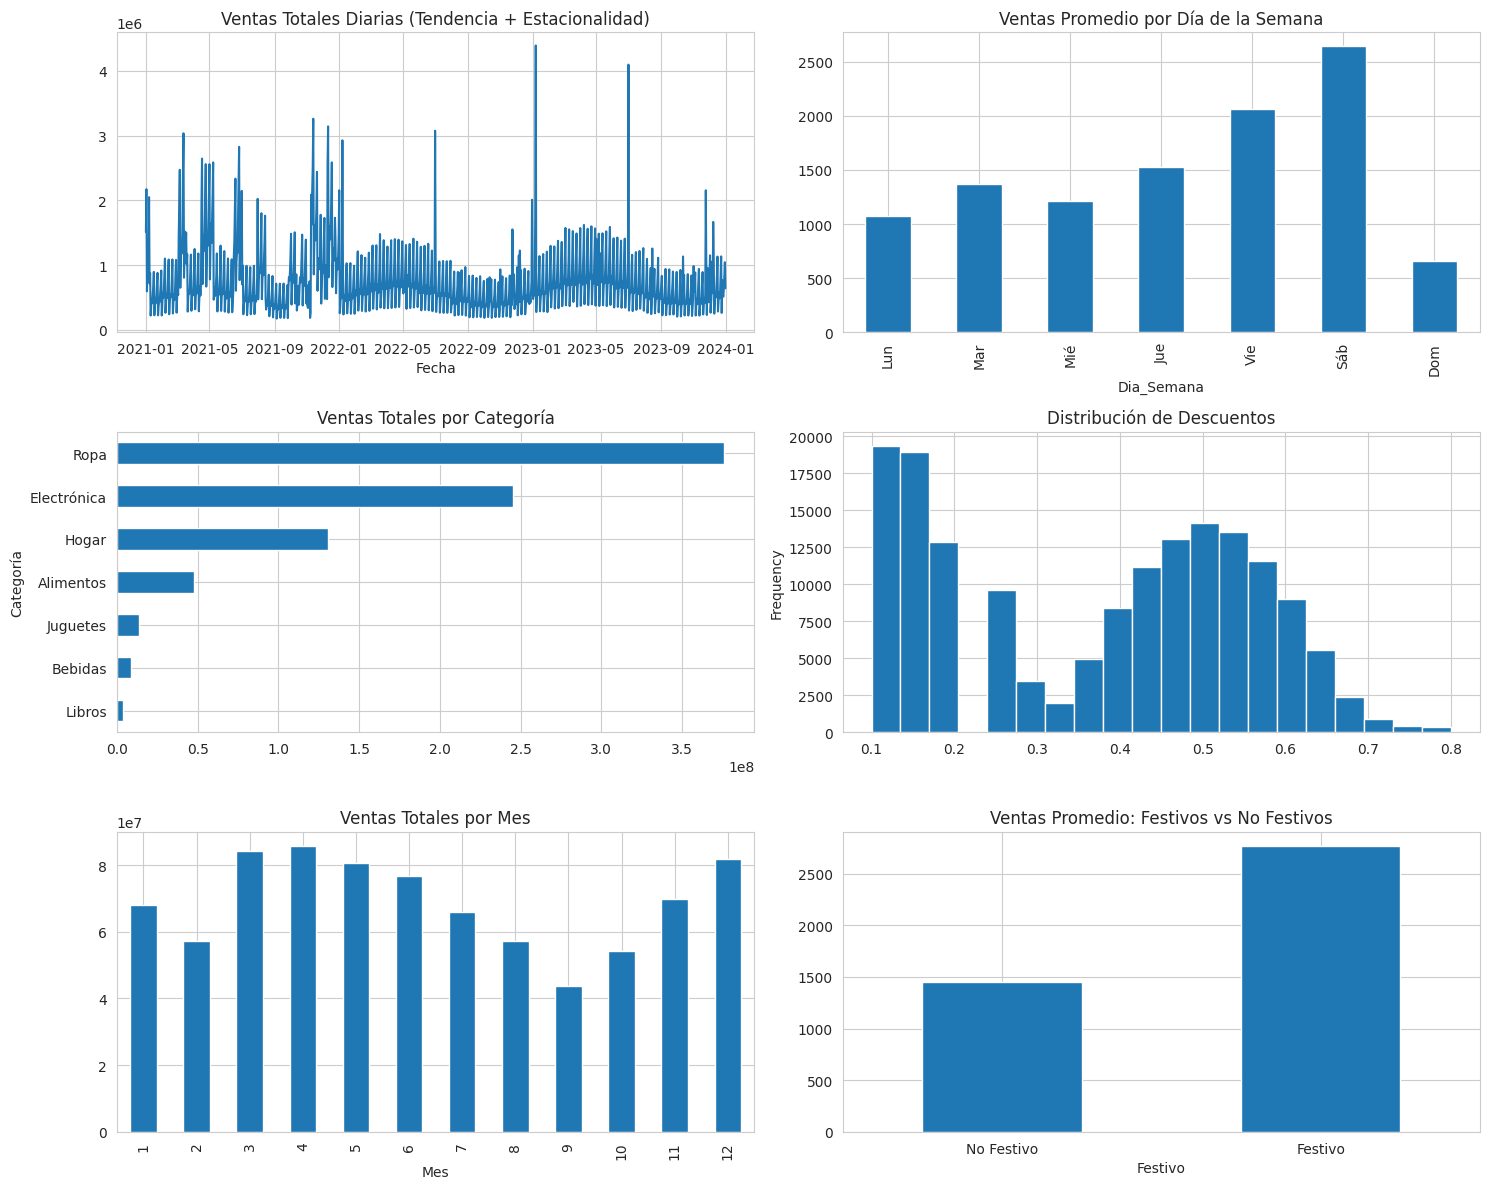

In [8]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Configuración
np.random.seed(42)
n_dias = 365 * 3  # 3 años de datos
n_productos = 50
n_tiendas = 10

# 1. Definir festivos nacionales de España + eventos comerciales
festivos_espana = {
    # Festivos nacionales
    (1, 1): "Año Nuevo",
    (1, 6): "Reyes Magos",
    (3, 19): "Día del Padre",
    (5, 1): "Día del Trabajo",
    (5, 9): "Día de la Madre",
    (8, 15): "Asunción",
    (10, 12): "Fiesta Nacional",
    (11, 1): "Todos los Santos",
    (12, 6): "Día de la Constitución",
    (12, 8): "Inmaculada Concepción",
    (12, 25): "Navidad",
    (12, 31): "Nochevieja",

    # Eventos comerciales
    (11, 24): "Black Friday",
    (11, 27): "Cyber Monday",
    (1, 7): "Rebajas de Invierno",
    (7, 1): "Rebajas de Verano"
}

# Diccionario inverso para búsqueda de fechas
festivos_fechas = {v: datetime(2021, k[0], k[1]).date() for k, v in festivos_espana.items()}

# 2. Funciones para festivos y efectos anticipatorios mejorados
def es_festivo(fecha):
    return (fecha.month, fecha.day) in festivos_espana

def obtener_tipo_festivo(fecha):
    return festivos_espana.get((fecha.month, fecha.day), "No festivo")

def aplicar_efecto_festivo(fecha, categoria):
    nombre_festivo = obtener_tipo_festivo(fecha)
    efecto = 1.0  # Base sin efecto

    # Efectos directos de festivos (más específicos por categoría)
    efectos_directos = {
    "Año Nuevo": {
        "Alimentos": 1.25,  # Original: 2.5
        "Bebidas": 1.5,    # Original: 3.0
    },
    "Nochevieja": {
        "Alimentos": 1.4,  # Original: 2.8
        "Bebidas": 1.6,    # Original: 3.2
    },
    "Navidad": {
        "Juguetes": 1.75,  # Original: 3.5
        "Alimentos": 1.0,  # Original: 2.0
        "Ropa": 0.75,      # Original: 1.5
        "Bebidas": 1.25,   # Original: 2.5
        "Hogar": 0.9,      # Original: 1.8
        "Libros": 0.75,    # Original: 1.5
        "Electrónica": 0.6 # Original: 1.2
    },
    "Reyes Magos": {
        "Juguetes": 2.0,   # Original: 4.0
        "Libros": 1.0,     # Original: 2.0
        "Ropa": 0.9,       # Original: 1.8
        "Electrónica": 0.75 # Original: 1.5
    },
    "Día del Padre": {
        "Ropa": 0.5,      # Original: 2.5
        "Electrónica": 0.5, # Original: 1.8
        "Hogar": 0.5,      # Original: 1.5
        "Libros": 0.5,      # Original: 1.2
    },
    "Día de la Madre": {
        "Ropa": 0.5,       # Original: 2.2
        "Hogar": 0.5,      # Original: 2.0
        "Libros": 0.5,    # Original: 1.5
    },
    "Black Friday": {
        "Electrónica": 1.5, # Original: 3.0
        "Hogar": 1.0,      # Original: 2.0
        "Libros": 0.9,     # Original: 1.8
        "Juguetes": 0.75   # Original: 1.5
    },
    "Cyber Monday": {
        "Electrónica": 1.4, # Original: 2.8
        "Libros": 1.0,     # Original: 2.0
    },
    "Rebajas de Invierno": {
        "Ropa": 1.5,       # Original: 3.0
         "Hogar": 0.9,      # Original: 1.8
    },
    "Rebajas de Verano": {
        "Ropa": 1.4,       # Original: 2.8
        "Hogar": 0.75,     # Original: 1.5
        "Bebidas": 0.6,    # Original: 1.2
   }
}

    # Efectos anticipatorios mejorados (días antes con progresión)
    efectos_previos = {
        "Navidad": [{"dias": i, "factor": 0.05*i} for i in range(15, 0, -1)],
        "Reyes Magos": [{"dias": i, "factor": 0.04*i} for i in range(10, 0, -1)],
        "Nochevieja": [{"dias": i, "factor": 0.03*i} for i in range(7, 0, -1)],
        "Día del Padre": [{"dias": i, "factor": 0.03*i} for i in range(7, 0, -1)],
        "Día de la Madre": [{"dias": i, "factor": 0.03*i} for i in range(7, 0, -1)],
        "Black Friday": [{"dias": i, "factor": 0.06*i} for i in range(15, 0, -1)],
        "Rebajas de Invierno": [{"dias": i, "factor": 0.04*i} for i in range(7, 0, -1)],
        "Rebajas de Verano": [{"dias": i, "factor": 0.04*i} for i in range(7, 0, -1)]
    }

    # Comprobar si es festivo
    if es_festivo(fecha):
        efecto = efectos_directos.get(nombre_festivo, {}).get(categoria, 1.0)
    else:
        # Comprobar días previos con efectos progresivos
        for festivo, previos in efectos_previos.items():
            fecha_festivo = festivos_fechas[festivo]
            for previo in previos:
                if fecha == fecha_festivo - timedelta(days=previo["dias"]):
                    # Añadir aleatoriedad al efecto
                    efecto = 1 + previo["factor"] * np.random.uniform(0.8, 1.2)
                    # Aplicar categorías específicas para anticipación
                    if festivo in ["Navidad", "Reyes Magos"] and categoria in ["Juguetes", "Libros"]:
                        efecto *= 1.5
                    elif festivo == "Black Friday" and categoria in ["Electrónica", "Ropa"]:
                        efecto *= 1.3
                    break

    return efecto

# 3. Generar datos maestros con lambdas diferentes por categoría
categorias = ['Electrónica', 'Ropa', 'Alimentos', 'Hogar', 'Juguetes', 'Libros', 'Bebidas']
lambdas_categorias = {
    'Electrónica': 3,
    'Ropa': 7,
    'Alimentos': 10,
    'Hogar': 4,
    'Juguetes': 2,
    'Libros': 2,
    'Bebidas': 6
}

productos = [f"SKU-{i:03d}" for i in range(n_productos)]
# Distribución de categorías más realista
categorias_productos = np.random.choice(
    categorias,
    size=n_productos,
    p=[0.15, 0.25, 0.15, 0.15, 0.1, 0.1, 0.1]
)

rangos_precios = {
    'Electrónica': (50, 2000),
    'Ropa': (10, 300),
    'Alimentos': (1, 100),
    'Hogar': (15, 500),
    'Juguetes': (5, 150),
    'Libros': (8, 80),
    'Bebidas': (1, 50)
}

precios_base = np.round([np.random.uniform(*rangos_precios[cat]) for cat in categorias_productos], 2)

tiendas = [f"Tienda-{i:02d}" for i in range(1, n_tiendas+1)]
regiones = np.random.choice(['Norte', 'Sur', 'Este', 'Oeste', 'Centro'], size=n_tiendas)

# 4. Generar dataset con tendencia anual creciente y días de semana diferenciados
data = []
for i, fecha in enumerate([datetime(2021,1,1) + timedelta(days=i) for i in range(n_dias)]):
    fecha = fecha.date()

    # Tasa de crecimiento anual compuesta del 12%
    factor_crecimiento = (1.12) ** (i / 365)

    # Definir periodo festivo (días antes de cada festivo)
    es_periodo_festivo = False
    for festivo_date in festivos_fechas.values():
        for d in range(0, 16):  # 15 días antes + día festivo
            if fecha == festivo_date - timedelta(days=d):
                es_periodo_festivo = True
                break
        if es_periodo_festivo:
            break

    for tienda_idx, tienda in enumerate(tiendas):
        for producto_idx, producto in enumerate(productos):
            # Variables base
            precio = precios_base[producto_idx]
            categoria = categorias_productos[producto_idx]
            lam = lambdas_categorias[categoria]

            # Descuentos más realistas por categoría y periodo
            if es_periodo_festivo or es_festivo(fecha):
                nombre_festivo = obtener_tipo_festivo(fecha)

                # Base de descuento según tipo de evento
                if "Rebajas" in nombre_festivo:
                    desc_base = 0.4  # 40% base en rebajas
                elif "Black Friday" in nombre_festivo:
                    desc_base = 0.35
                else:
                    desc_base = 0.25  # 25% en otros festivos

                # Ajuste por categoría
                desc_cat = {
                    'Electrónica': 0.15,
                    'Ropa': 0.25,
                    'Alimentos': 0.1,
                    'Hogar': 0.2,
                    'Juguetes': 0.3,
                    'Libros': 0.15,
                    'Bebidas': 0.1
                }[categoria]

                # Variabilidad por tienda y aleatoriedad
                desc_tienda = tienda_idx * 0.015  # Tienda 01: +0%, Tienda 10: +0.135%
                descuento = min(0.8, max(0.1, desc_base + desc_cat + desc_tienda + np.random.uniform(-0.05, 0.05)))
            else:
                # Descuentos menores fuera de festivos (0-30%)
                prob_descuento = 0.25 if fecha.weekday() in [4,5] else 0.1  # Más descuentos en viernes y sábados
                if np.random.random() < prob_descuento:
                    descuento = np.random.choice([0.1, 0.15, 0.2, 0.25, 0.3], p=[0.3, 0.3, 0.2, 0.15, 0.05])
                else:
                    descuento = 0

            precio_final = precio * (1 - descuento)

            # Factores temporales con días de semana diferenciados
            mes = fecha.month
            dia_semana = fecha.weekday()

            # Probabilidades de venta por día de semana (0=lunes, 6=domingo)
            factores_dia_semana = {
                0: 0.8,  # Lunes
                1: 1.0,  # Martes
                2: 0.9,  # Miércoles
                3: 1.1,  # Jueves
                4: 1.4,  # Viernes
                5: 1.8,  # Sábado
                6: 0.5   # Domingo
            }

            factor_dia = factores_dia_semana[dia_semana] * np.random.uniform(0.9, 1.1)

            # Estacionalidad con tendencia anual creciente
            factor_estacional = (1 + 0.3 * np.sin(2*np.pi*(mes-1)/12)) * factor_crecimiento

            # Efecto festivo/anticipatorio mejorado
            factor_festivo = aplicar_efecto_festivo(fecha, categoria)

            # Cálculo de ventas con lambdas por categoría
            ventas_base = np.random.poisson(lam=lam)

            # Añadir factor de sensibilidad al precio (elasticidad)
            elasticidad_precio = {
                'Electrónica': -1.2,
                'Ropa': -1.8,
                'Alimentos': -0.8,
                'Hogar': -1.2,
                'Juguetes': -2.0,
                'Libros': -1.0,
                'Bebidas': -0.7
            }[categoria]

            factor_precio = (precio_final / precio) ** elasticidad_precio

            cantidad = int(max(1, ventas_base * factor_estacional * factor_dia * factor_festivo * factor_precio * (1 + 0.9*descuento)))

            data.append({
                'Fecha': fecha,
                'Tienda': tienda,
                'Región': regiones[tienda_idx],
                'Producto': producto,
                'Categoría': categoria,
                'Precio_Base': precio,
                'Descuento': descuento,
                'Precio_Final': precio_final,
                'Cantidad_Vendida': cantidad,
                'Ventas': cantidad * precio_final,
                'Dia_Semana': dia_semana,
                'Mes': mes,
                'Festivo': es_festivo(fecha),
                'Periodo_Festivo': es_periodo_festivo,
                'Nombre_Festivo': obtener_tipo_festivo(fecha),
                'Promoción': descuento > 0
            })

# 5. Crear y guardar DataFrame
df = pd.DataFrame(data)
df.to_csv('dataset_ventas_retail_espana_final_v3.csv', index=False, encoding='utf-8-sig')
print("Dataset mejorado generado con éxito!")
print(f"Registros: {len(df):,} | Periodo: {df['Fecha'].min()} al {df['Fecha'].max()}")

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

# Ventas totales diarias
plt.subplot(3, 2, 1)
df.groupby('Fecha')['Ventas'].sum().plot(title='Ventas Totales Diarias (Tendencia + Estacionalidad)')
plt.grid(True)

# Ventas por día de la semana
plt.subplot(3, 2, 2)
df.groupby('Dia_Semana')['Ventas'].mean().plot(kind='bar', title='Ventas Promedio por Día de la Semana')
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
plt.grid(True)

# Ventas por categoría
plt.subplot(3, 2, 3)
df.groupby('Categoría')['Ventas'].sum().sort_values().plot(kind='barh', title='Ventas Totales por Categoría')
plt.grid(True)

# Descuentos aplicados
plt.subplot(3, 2, 4)
df[df['Descuento'] > 0]['Descuento'].plot(kind='hist', bins=20, title='Distribución de Descuentos')
plt.grid(True)

# Ventas por mes
plt.subplot(3, 2, 5)
df.groupby('Mes')['Ventas'].sum().plot(kind='bar', title='Ventas Totales por Mes')
plt.grid(True)

# Ventas en festivos vs no festivos
plt.subplot(3, 2, 6)
df.groupby('Festivo')['Ventas'].mean().plot(kind='bar', title='Ventas Promedio: Festivos vs No Festivos')
plt.xticks([0, 1], ['No Festivo', 'Festivo'], rotation=0)
plt.grid(True)

plt.tight_layout()
plt.show()